In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

In [2]:
class MTMOGP(gpytorch.models.ExactGP):

    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))

        super(MTMOGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [3]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df_x = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 0, usecols = [1,2,3,4])
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
print(len(df_x))
df_x.head()

24


,Buffer_Type,pH,Sugar_Salt,Additive
0,Ace,4.5,4% Sorbitol,Arginine
1,Ace,4.5,4% Sorbitol,Glycine
2,Ace,5.0,4% Sorbitol,Arginine
3,Ace,5.0,4% Sorbitol,Glycine
4,Ace,5.0,0.1M NaCl,Glycine


In [4]:

df_y_1 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [1,4,7],skiprows = lambda x: x in [1])
df_y_1.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_y_1.columns]
print(len(df_y_1))
print(df_y_1.head())

df_y_2 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [2,5,8],skiprows = lambda x: x in [1])
df_y_2.columns = df_y_1.columns
print(len(df_y_2))
print(df_y_2.head())

df_y_3 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [3,6,9],skiprows = lambda x: x in [1])
df_y_3.columns = df_y_1.columns
print(len(df_y_3))
print(df_y_3.head())

24
   _Dimer_HMW_  _Monomer  _LMW
0          2.4      95.1   2.5
1          0.8      97.3   2.0
2          3.2      94.3   2.6
3          1.4      96.7   1.9
4          4.2      93.3   2.5
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.6      96.2   2.2
1          1.1      96.6   2.2
2          2.0      95.6   2.4
3          1.4      96.4   2.3
4          2.3      95.2   2.4
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.8      93.8   4.4
1          0.7      95.1   4.2
2          2.7      93.4   3.9
3          1.3      95.0   3.6
4          3.4      92.7   4.0


In [5]:
cols_feature01 = list(df_x.columns)
cols_target = list(df_y_1.columns)[0:2]
#cols_target = ['UP_SEC_HMW','UP_SEC_LMW']
cols_cate = ['Buffer_Type',
 'Sugar_Salt',
 'Additive']

In [6]:
df_y_1.columns = [c+'_1' for c in df_y_1.columns]
df_y_2.columns = [c+'_2' for c in df_y_2.columns]
df_y_3.columns = [c+'_3' for c in df_y_3.columns]


In [7]:
total_df = pd.concat((df_x,df_y_1,df_y_2,df_y_3),axis = 1)

#convert Buffer column to labels
for x_name in cols_cate:
    labels, categories = factorize(total_df[x_name])
    total_df[x_name+"_label"] = labels

In [8]:
#onehot encoding
total_df = pd.get_dummies(total_df, columns = cols_cate)
#print(total_df.head())
total_df.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in total_df.columns]

#convert boolean True False to 0 1
bool_cols = total_df.select_dtypes(include='bool').columns
total_df[bool_cols] = total_df[bool_cols].astype(int)
print(total_df.head())



    pH  _Dimer_HMW_1  _Monomer_1  _LMW_1  _Dimer_HMW_2  _Monomer_2  _LMW_2  \
0  4.5           2.4        95.1     2.5           1.6        96.2     2.2   
1  4.5           0.8        97.3     2.0           1.1        96.6     2.2   
2  5.0           3.2        94.3     2.6           2.0        95.6     2.4   
3  5.0           1.4        96.7     1.9           1.4        96.4     2.3   
4  5.0           4.2        93.3     2.5           2.3        95.2     2.4   

   _Dimer_HMW_3  _Monomer_3  _LMW_3  ...  Sugar_Salt_label  Additive_label  \
0           1.8        93.8     4.4  ...                 0               0   
1           0.7        95.1     4.2  ...                 0               1   
2           2.7        93.4     3.9  ...                 0               0   
3           1.3        95.0     3.6  ...                 0               1   
4           3.4        92.7     4.0  ...                 1               1   

   Buffer_Type_Ace  Buffer_Type_Cit  Buffer_Type_His  Buffer_T

In [9]:
ls_model = ['simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'multi-task-multi-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-stand'
cate_transform_option = 'ohe'
#remove_pred_outlier_option= 0

output_rank_option = 2 #if 0, no correlation between output
task_rank_option = 3#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'

noise_option = 0 #noise percentage

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option
#remove_pred_outlier_label = 'remove_pred_outlier_'+str(remove_pred_outlier_option)
output_rank_label = 'output_rank_'+str(output_rank_option)
task_rank_label = 'task_rank_'+str(task_rank_option)
lik_rank_label = 'lik_rank_'+str(lik_rank_option)
split_label = split_option
stratify_label = stratify_option
if noise_option>0:
        noise_label = 'noise_'+str(noise_option)
else:
        noise_label = ''

folder_name = '-'.join([model_label,task_rank_label,output_rank_label,lik_rank_label,x_scale_label,y_scale_label,cate_transform_label,
                        split_label,stratify_label,noise_label])

#figPath = 'output/hierarchy-output-harpoon-y-task-scale/'+folder_name
figPath = 'output/hierarchy-output-harpoon-0721/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output/hierarchy-output-harpoon-0721/multi-task-multi-output-task_rank_3-output_rank_2-lik_rank_1-x-minmax-y-stand-cate_transform_ohe-mix-stratify-x-


In [10]:
if cate_transform_option == 'label':
    cols_feature_new = ['pH'] + ['Buffer_Type_label', 'Sugar_Salt_label',
       'Additive_label']
else:
    cols_feature_new = ['pH'] + list(bool_cols)

cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']
#cols_target_new = ['UP_SEC_HMW_1','UP_SEC_LMW_1',	'UP_SEC_HMW_3',	'UP_SEC_LMW_3','UP_SEC_HMW_5','UP_SEC_LMW_5']

if split_label == 'mix':
    ls_X = [total_df[cols_feature_new],
            total_df[cols_feature_new],
            total_df[cols_feature_new]]
    
    for i,df_x in enumerate(ls_X):
        df_x['task_ind'] = i

    df_X = pd.concat(ls_X)
    df_X.reset_index(inplace=True, drop = True)
    #print(df_X.head())

    arr_Y = np.concatenate((df_y_1.to_numpy()[:,:2],
                            df_y_2.to_numpy()[:,:2],
                            df_y_3.to_numpy()[:,:2]))
    df_Y = pd.DataFrame(arr_Y,columns= cols_target)
    #print(df_Y.head())

else:
    df_X = total_df[cols_feature_new]
    #print(df_X.head())

    df_Y = total_df[cols_target_new]
    #print(df_Y.head())

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_11933/4039460875.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['task_ind'] = i
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_11933/4039460875.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['task_ind'] = i
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_11933/4039460875.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [415]:
if stratify_label =='stratify-y' or stratify_label =='stratify-xy':
    labels = [0,1]
    df_Y['_Dimer_HMW_binned'] = pd.cut(df_Y['_Dimer_HMW_'], bins=2, labels=labels)
    df_Y['_Monomer_binned'] = pd.cut(df_Y['_Monomer'], bins=2, labels=labels)

    if stratify_label =='stratify-xy':
        df_Y['stratify_xy_label'] =  df_X['task_ind'].astype(str) + df_Y['_Dimer_HMW_binned'].astype(str) + df_Y['_Monomer_binned'].astype(str)
        df_Y.loc[df_Y['stratify_xy_label'] == '211','stratify_xy_label'] = '210' #class '211' only has one member
    elif stratify_label =='stratify-y':
        df_Y['stratify_y_label'] = df_Y['_Dimer_HMW_binned'].astype(str) + df_Y['_Monomer_binned'].astype(str)
    
    print(df_Y)


In [434]:
np.random.seed(42)
N = len(df_X)
#percentage = 0.05
if noise_option>0:
#create data with noise
    df_X_syn = df_X.copy()
    for col in df_X.columns.difference(['task_ind']):
        df_X_syn[col] = df_X_syn[col] + np.random.normal(0, df_X_syn[col].std(), N) * noise_option

    df_Y_syn= df_Y[cols_target].copy()
    for col in cols_target:
        df_Y_syn[col] = df_Y_syn[col] + np.random.normal(0, df_Y_syn[col].std(), N) * noise_option

In [12]:
#split train and test data
if noise_option>0:
    df_total_X = pd.concat((df_X,df_X_syn))
    df_total_Y = pd.concat((df_Y[cols_target],df_Y_syn))
else:
    df_total_X = df_X
    df_total_Y = df_Y
if stratify_label =='stratify-x':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_total_X, 
                                                                    df_total_Y, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                stratify=df_total_X['task_ind'])
elif stratify_label =='stratify-y':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_Y[cols_target], 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                stratify=df_Y['stratify_y_label'])
elif stratify_label =='stratify-xy':
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_Y[cols_target], 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                stratify=df_Y['stratify_xy_label'])
else:
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_total_X, 
                                                                    df_total_Y, 
                                                                test_size=0.2, 
                                                                random_state=0)

array([[<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'Buffer_Type_Ace'}>,
        <Axes: title={'center': 'Buffer_Type_Cit'}>],
       [<Axes: title={'center': 'Buffer_Type_His'}>,
        <Axes: title={'center': 'Buffer_Type_Phos'}>,
        <Axes: title={'center': 'Sugar_Salt_0_1M_NaCl'}>],
       [<Axes: title={'center': 'Sugar_Salt_4_Sorbitol'}>,
        <Axes: title={'center': 'Additive_Arginine'}>,
        <Axes: title={'center': 'Additive_Glycine'}>],
       [<Axes: title={'center': 'task_ind'}>, <Axes: >, <Axes: >]],
      dtype=object)

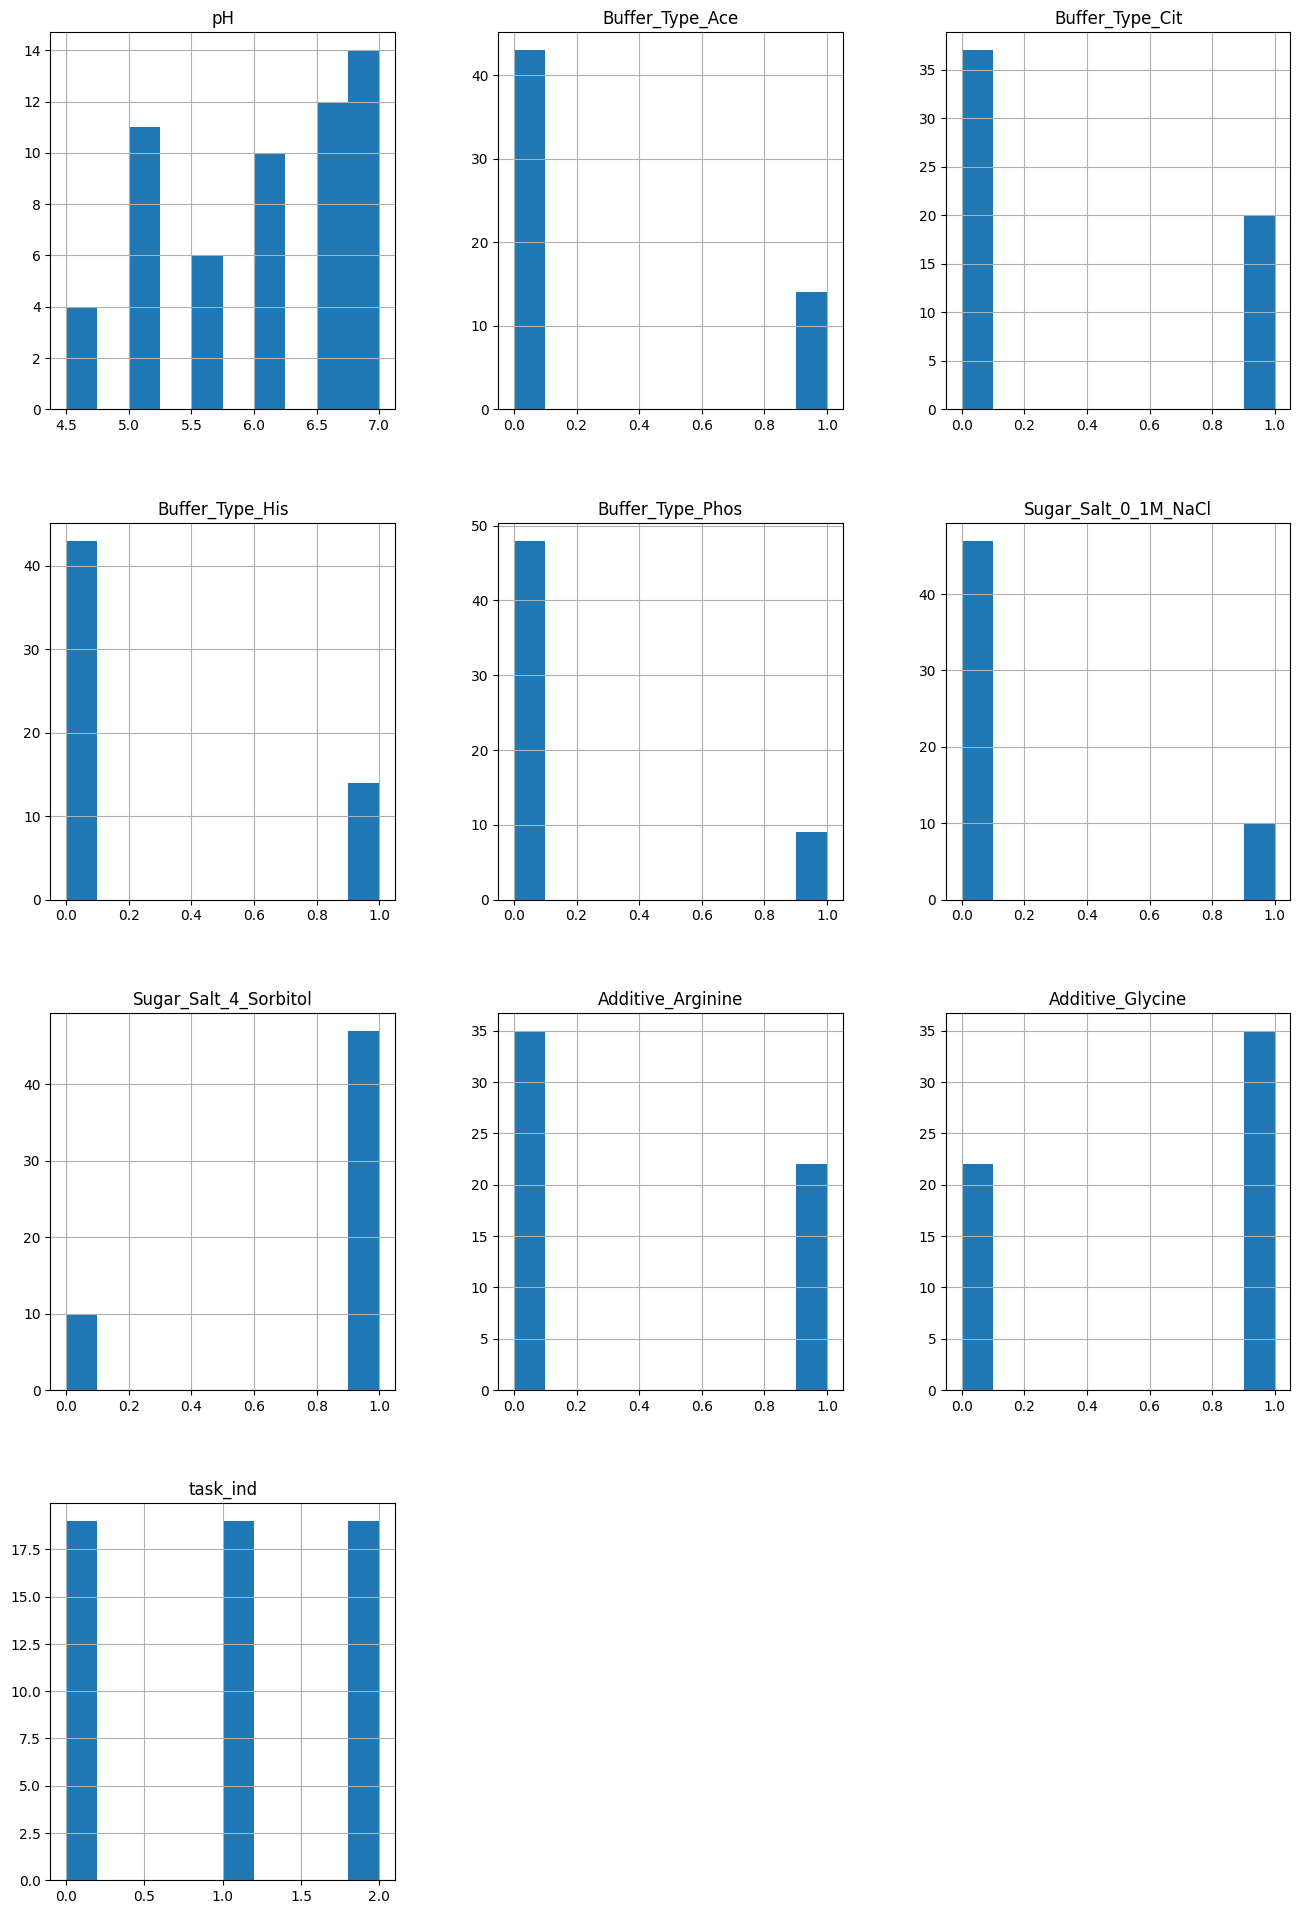

In [13]:
df_X_train.hist(figsize = (16,24))

In [14]:
# scale features
#x_mm_scaler = MinMaxScaler()
#keep the last task indices column untouched !!!
xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_mm_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_mm_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)


#if y_scale_option==1:
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
    """
    scaled_y_train = np.zeros_like(df_y_train.to_numpy())
    scaled_y_test = np.zeros_like(df_y_test.to_numpy())
    ls_y_task_scaler = []
    ls_row_idx_train = []
    ls_row_idx_test = []
    for task_ind in range(3):
        y_task_scaler = StandardScaler()
        row_idx_train = np.where(df_X_train['task_ind']==task_ind)[0]
        ls_row_idx_train.append(row_idx_train)
        row_idx_test = np.where(df_X_test['task_ind']==task_ind)[0]
        ls_row_idx_test.append(row_idx_test)
        scaled_y_train_task =y_task_scaler.fit_transform(df_y_train[df_X_train['task_ind']==task_ind])
        scaled_y_test_task= y_task_scaler.transform(df_y_test[df_X_test['task_ind']==task_ind])
        ls_y_task_scaler.append(y_task_scaler)
        scaled_y_train[row_idx_train] = scaled_y_train_task
        scaled_y_test[row_idx_test] = scaled_y_test_task
    """
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

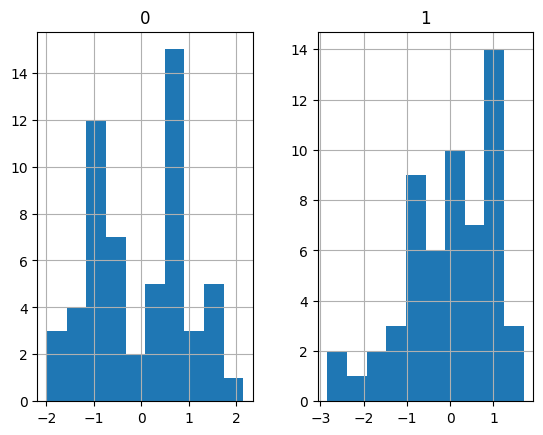

In [15]:
df_scaled_y_train = pd.DataFrame(scaled_y_train)
df_scaled_y_train.hist()

array([[<Axes: title={'center': '_Dimer_HMW_'}>,
        <Axes: title={'center': '_Monomer'}>]], dtype=object)

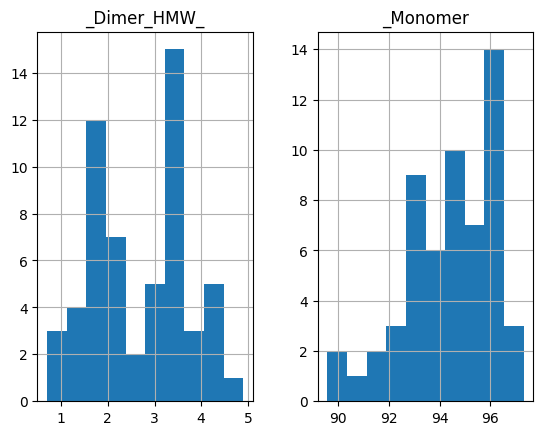

In [16]:
df_y_train.hist()

In [17]:
#if y_scale_option>0:
if y_scale_label != 'no-y-scale':
    t_train_y = torch.Tensor(scaled_y_train)
else:
    t_train_y = torch.Tensor(df_y_train.to_numpy())

#if x_scale_option>0:
if x_scale_label != 'no-x-scale':
    t_train_x = torch.Tensor(scaled_X_train)
else:
    t_train_x = torch.Tensor(df_X_train.to_numpy())

In [18]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = output_rank_option
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MTMOGP(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)

In [19]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 200 #100
loss_list = []
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss_list.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403210267/work/torch/csrc/utils/tensor_new.cpp:620.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/200 - Loss: 1.824
Iter 2/200 - Loss: 1.717
Iter 3/200 - Loss: 1.612
Iter 4/200 - Loss: 1.514
Iter 5/200 - Loss: 1.424
Iter 6/200 - Loss: 1.344
Iter 7/200 - Loss: 1.273
Iter 8/200 - Loss: 1.208
Iter 9/200 - Loss: 1.149
Iter 10/200 - Loss: 1.095
Iter 11/200 - Loss: 1.045
Iter 12/200 - Loss: 1.001
Iter 13/200 - Loss: 0.965
Iter 14/200 - Loss: 0.936
Iter 15/200 - Loss: 0.907
Iter 16/200 - Loss: 0.875
Iter 17/200 - Loss: 0.836
Iter 18/200 - Loss: 0.791
Iter 19/200 - Loss: 0.745
Iter 20/200 - Loss: 0.702
Iter 21/200 - Loss: 0.662
Iter 22/200 - Loss: 0.624
Iter 23/200 - Loss: 0.588
Iter 24/200 - Loss: 0.554
Iter 25/200 - Loss: 0.525
Iter 26/200 - Loss: 0.499
Iter 27/200 - Loss: 0.477
Iter 28/200 - Loss: 0.456
Iter 29/200 - Loss: 0.435
Iter 30/200 - Loss: 0.410
Iter 31/200 - Loss: 0.382
Iter 32/200 - Loss: 0.355
Iter 33/200 - Loss: 0.333
Iter 34/200 - Loss: 0.317
Iter 35/200 - Loss: 0.306
Iter 36/200 - Loss: 0.295
Iter 37/200 - Loss: 0.278
Iter 38/200 - Loss: 0.262
Iter 39/200 - Loss: 0

Text(0.5, 1.0, 'Neg. Loss')

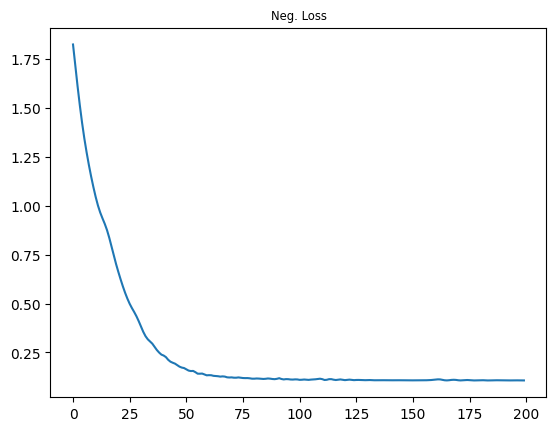

In [20]:
plt.plot(loss_list)
plt.title('Neg. Loss', fontsize='small')

In [21]:
task_kern = model.task_kernel
covar_factor = task_kern.covar_factor
print('W W^T + diag(v) is the task kernel covariance matrix: ')
B = task_kern._eval_covar_matrix().detach().numpy()
print(B)

print('---Manually calculating covariance matrix---')
W = covar_factor.detach().numpy()
print('W W^T + diag(v) is the task kernel covariance matrix: ')
print(np.dot(W,W.T)+np.diag(task_kern.var.detach().numpy()))

print('Correlation matrix between tasks')
C = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))
print(C)


W W^T + diag(v) is the task kernel covariance matrix: 
[[5.241515   1.7842668  4.858844  ]
 [1.7842668  0.61714035 1.4770006 ]
 [4.858844   1.4770006  7.8349376 ]]
---Manually calculating covariance matrix---
W W^T + diag(v) is the task kernel covariance matrix: 
[[5.241515   1.7842668  4.858844  ]
 [1.7842668  0.61714035 1.4770006 ]
 [4.858844   1.4770006  7.8349376 ]]
Correlation matrix between tasks
[[0.9999999  0.9920633  0.7582052 ]
 [0.9920633  0.99999994 0.67169315]
 [0.7582052  0.67169315 1.        ]]


In [22]:
output_kern = model.output_kernel
covar_factor = output_kern.covar_factor
print('W W^T + diag(v) is the output kernel covariance matrix: ')
B = output_kern._eval_covar_matrix().detach().numpy()
print(B)

print('---Manually calculating covariance matrix---')
W = covar_factor.detach().numpy()
print('W W^T + diag(v) is the output kernel covariance matrix: ')
print(np.dot(W,W.T)+np.diag(output_kern.var.detach().numpy()))

print('Correlation matrix between tasks')
C = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))
print(C)

W W^T + diag(v) is the output kernel covariance matrix: 
[[ 0.67683834 -0.4574682 ]
 [-0.4574682   0.3885603 ]]
---Manually calculating covariance matrix---
W W^T + diag(v) is the output kernel covariance matrix: 
[[ 0.67683834 -0.4574682 ]
 [-0.4574682   0.3885603 ]]
Correlation matrix between tasks
[[ 0.99999994 -0.89205015]
 [-0.89205     1.0000001 ]]


In [23]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [35]:
df_X_test

,pH,Buffer_Type_Ace,Buffer_Type_Cit,Buffer_Type_His,Buffer_Type_Phos,Sugar_Salt_0_1M_NaCl,Sugar_Salt_4_Sorbitol,Additive_Arginine,Additive_Glycine,task_ind
3,5.0,1,0,0,0,0,1,0,1,0
43,7.0,0,1,0,0,0,1,1,0,1
48,4.5,1,0,0,0,0,1,1,0,2
0,4.5,1,0,0,0,0,1,1,0,0
12,5.0,0,1,0,0,0,1,1,0,0
32,6.0,0,0,1,0,0,1,0,1,1
44,6.5,0,0,0,1,0,1,1,0,1
59,6.5,0,0,1,0,0,1,0,1,2
58,6.5,0,0,1,0,0,1,1,0,2
15,6.5,0,1,0,0,0,1,1,0,0


In [40]:
t_test_x_sample = t_test_x[:4,...]
print(t_test_x_sample.shape)
task_term = model.task_kernel(t_test_x_sample[..., -1].long())
task_term_value = task_term.evaluate()
print(task_term_value)

torch.Size([4, 10])
tensor([[5.2415, 1.7843, 4.8588, 5.2415],
        [1.7843, 0.6171, 1.4770, 1.7843],
        [4.8588, 1.4770, 7.8349, 4.8588],
        [5.2415, 1.7843, 4.8588, 5.2415]], grad_fn=<SumBackward1>)


In [41]:
data_term = model.data_kernel(t_test_x_sample[..., :-1])
data_term_value = data_term.evaluate()
data_term_value

tensor([[1.0000, 0.5908, 0.7761, 0.7761],
        [0.5908, 1.0000, 0.6985, 0.6985],
        [0.7761, 0.6985, 1.0000, 1.0000],
        [0.7761, 0.6985, 1.0000, 1.0000]], grad_fn=<MaternCovarianceBackward>)

In [44]:
data_and_task_x = model.data_kernel(t_test_x_sample[..., :-1]).mul(task_term)
data_and_task_x.evaluate()

tensor([[5.2415, 1.0541, 3.7710, 4.0680],
        [1.0541, 0.6171, 1.0317, 1.2463],
        [3.7710, 1.0317, 7.8349, 4.8588],
        [4.0680, 1.2463, 4.8588, 5.2415]], grad_fn=<MulBackward0>)

In [24]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [25]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

    """
    arr_train_y = np.zeros((t_train_y.shape[0],2))
    arr_train_mean = np.zeros((t_train_y.shape[0],2))
    arr_train_lower = np.zeros((t_train_y.shape[0],2))
    arr_train_upper = np.zeros((t_train_y.shape[0],2))
    arr_test_mean  = np.zeros((t_test_y.shape[0],2))
    arr_test_lower = np.zeros((t_test_y.shape[0],2))
    arr_test_upper = np.zeros((t_test_y.shape[0],2))
    
    for task_ind in range(3):
        y_task_scaler = ls_y_task_scaler[task_ind]
        arr_train_y_task = y_task_scaler.inverse_transform(t_train_y[ls_row_idx_train[task_ind]])
        arr_train_mean_task  = y_task_scaler.inverse_transform(train_mean[ls_row_idx_train[task_ind]])
        arr_train_lower_task  = y_task_scaler.inverse_transform(train_lower[ls_row_idx_train[task_ind]])
        arr_train_upper_task  = y_task_scaler.inverse_transform(train_upper[ls_row_idx_train[task_ind]])
        arr_test_mean_task  = y_task_scaler.inverse_transform(test_mean[ls_row_idx_test[task_ind]])
        arr_test_lower_task  = y_task_scaler.inverse_transform(test_lower[ls_row_idx_test[task_ind]])
        arr_test_upper_task  = y_task_scaler.inverse_transform(test_upper[ls_row_idx_test[task_ind]])
        arr_train_y[[ls_row_idx_train[task_ind]]] = arr_train_y_task
        arr_train_mean[[ls_row_idx_train[task_ind]]] = arr_train_mean_task
        arr_train_lower[[ls_row_idx_train[task_ind]]] = arr_train_lower_task
        arr_train_upper[[ls_row_idx_train[task_ind]]] = arr_train_upper_task

        arr_test_mean[[ls_row_idx_test[task_ind]]] = arr_test_mean_task
        arr_test_lower[[ls_row_idx_test[task_ind]]] = arr_test_lower_task
        arr_test_upper[[ls_row_idx_test[task_ind]]] = arr_test_upper_task
    """

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_11933/2360520893.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_11933/2360520893.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_11933/2360520893.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

             _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE                  0.22        0.22          0.11        0.15          0.33   
MAE2                 0.19        0.23          0.10        0.11          0.30   
MSE                  0.07        0.05          0.01        0.04          0.14   
RMSE                 0.27        0.23          0.12        0.19          0.38   
MAPE                 0.08        0.00          0.06        0.00          0.12   
MAXE                 0.44        0.31          0.16        0.36          0.60   
EVS                  0.82        0.92          0.98        0.84          0.89   
R2                   0.82        0.92          0.79        0.60          0.89   
AVG_STD_PCT          0.17        0.01          0.18        0.01          0.17   
MIN_STD_PCT          0.13        0.01          0.17        0.01          0.13   
MAX_STD_PCT          0.22        0.01          0.18        0.01          0.19   

             _Monomer_3  
M

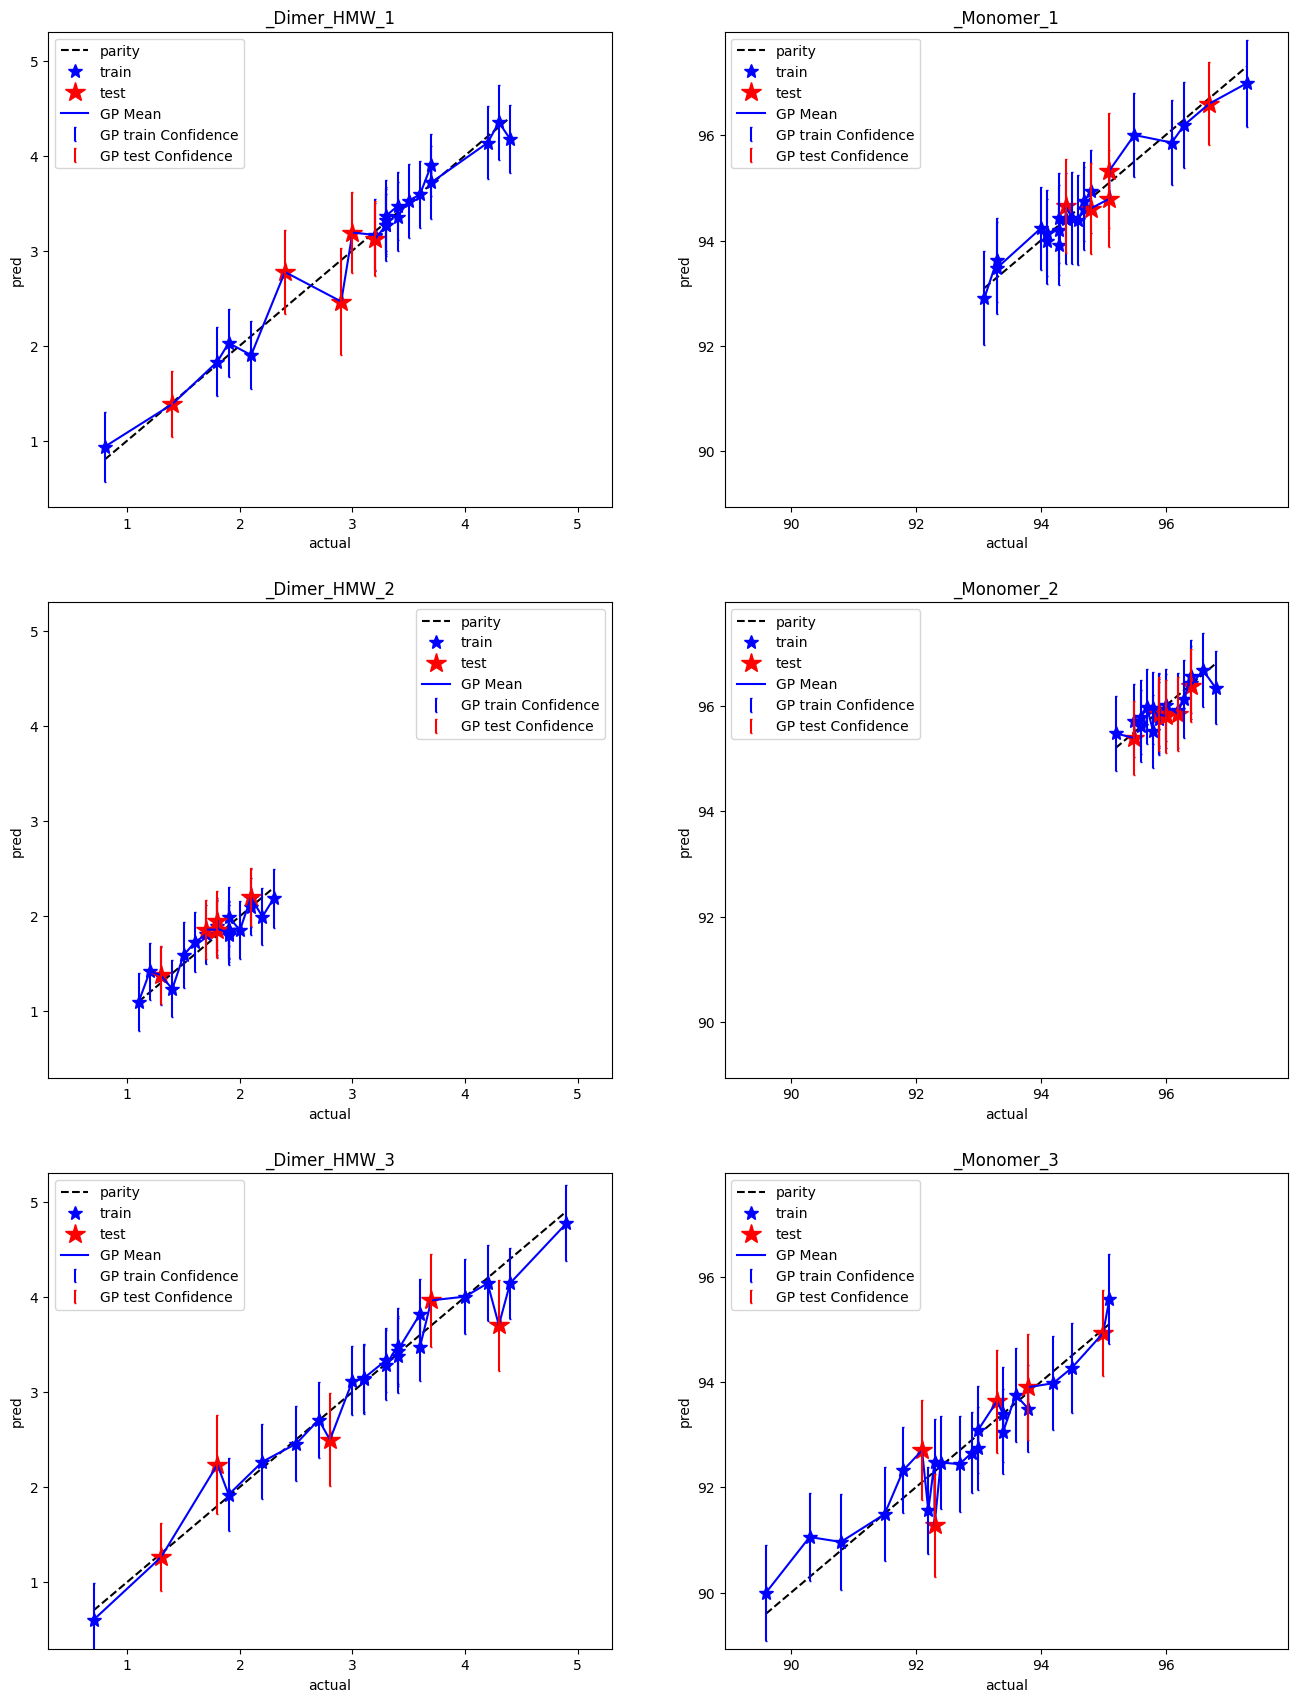

In [26]:
uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = True

plot_axis_lb = df_Y[cols_target].min(axis = 0) - 0.4*df_Y[cols_target].std(axis = 0)
plot_axis_ub = df_Y[cols_target].max(axis = 0) + 0.4* df_Y[cols_target].std(axis = 0)

num_outputs = arr_train_y.shape[-1]
num_tasks = len(np.unique(arr_train_x[..., -1]))

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]
    
    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as black stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'b*',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'r*',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std)/np.mean(y_true),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## change to 0-1 scale

In [446]:
t_test_y = torch.Tensor(scaled_y_test)

if True:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()


             _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE                  0.21        0.13          0.11        0.09          0.33   
MAE2                 0.17        0.12          0.11        0.08          0.31   
MSE                  0.07        0.02          0.01        0.01          0.14   
RMSE                 0.27        0.14          0.12        0.12          0.38   
MAPE                 0.86        3.84          0.13        0.10          0.97   
MAXE                 0.42        0.19          0.16        0.21          0.59   
EVS                  0.82        0.91          0.98        0.84          0.89   
R2                   0.82        0.91          0.78        0.56          0.88   
AVG_STD_PCT         -3.29        1.13         -0.32        0.44          7.17   
MIN_STD_PCT         -2.60        0.98         -0.31        0.44          5.47   
MAX_STD_PCT         -4.31        1.37         -0.32        0.44          7.95   

             _Monomer_3  
M

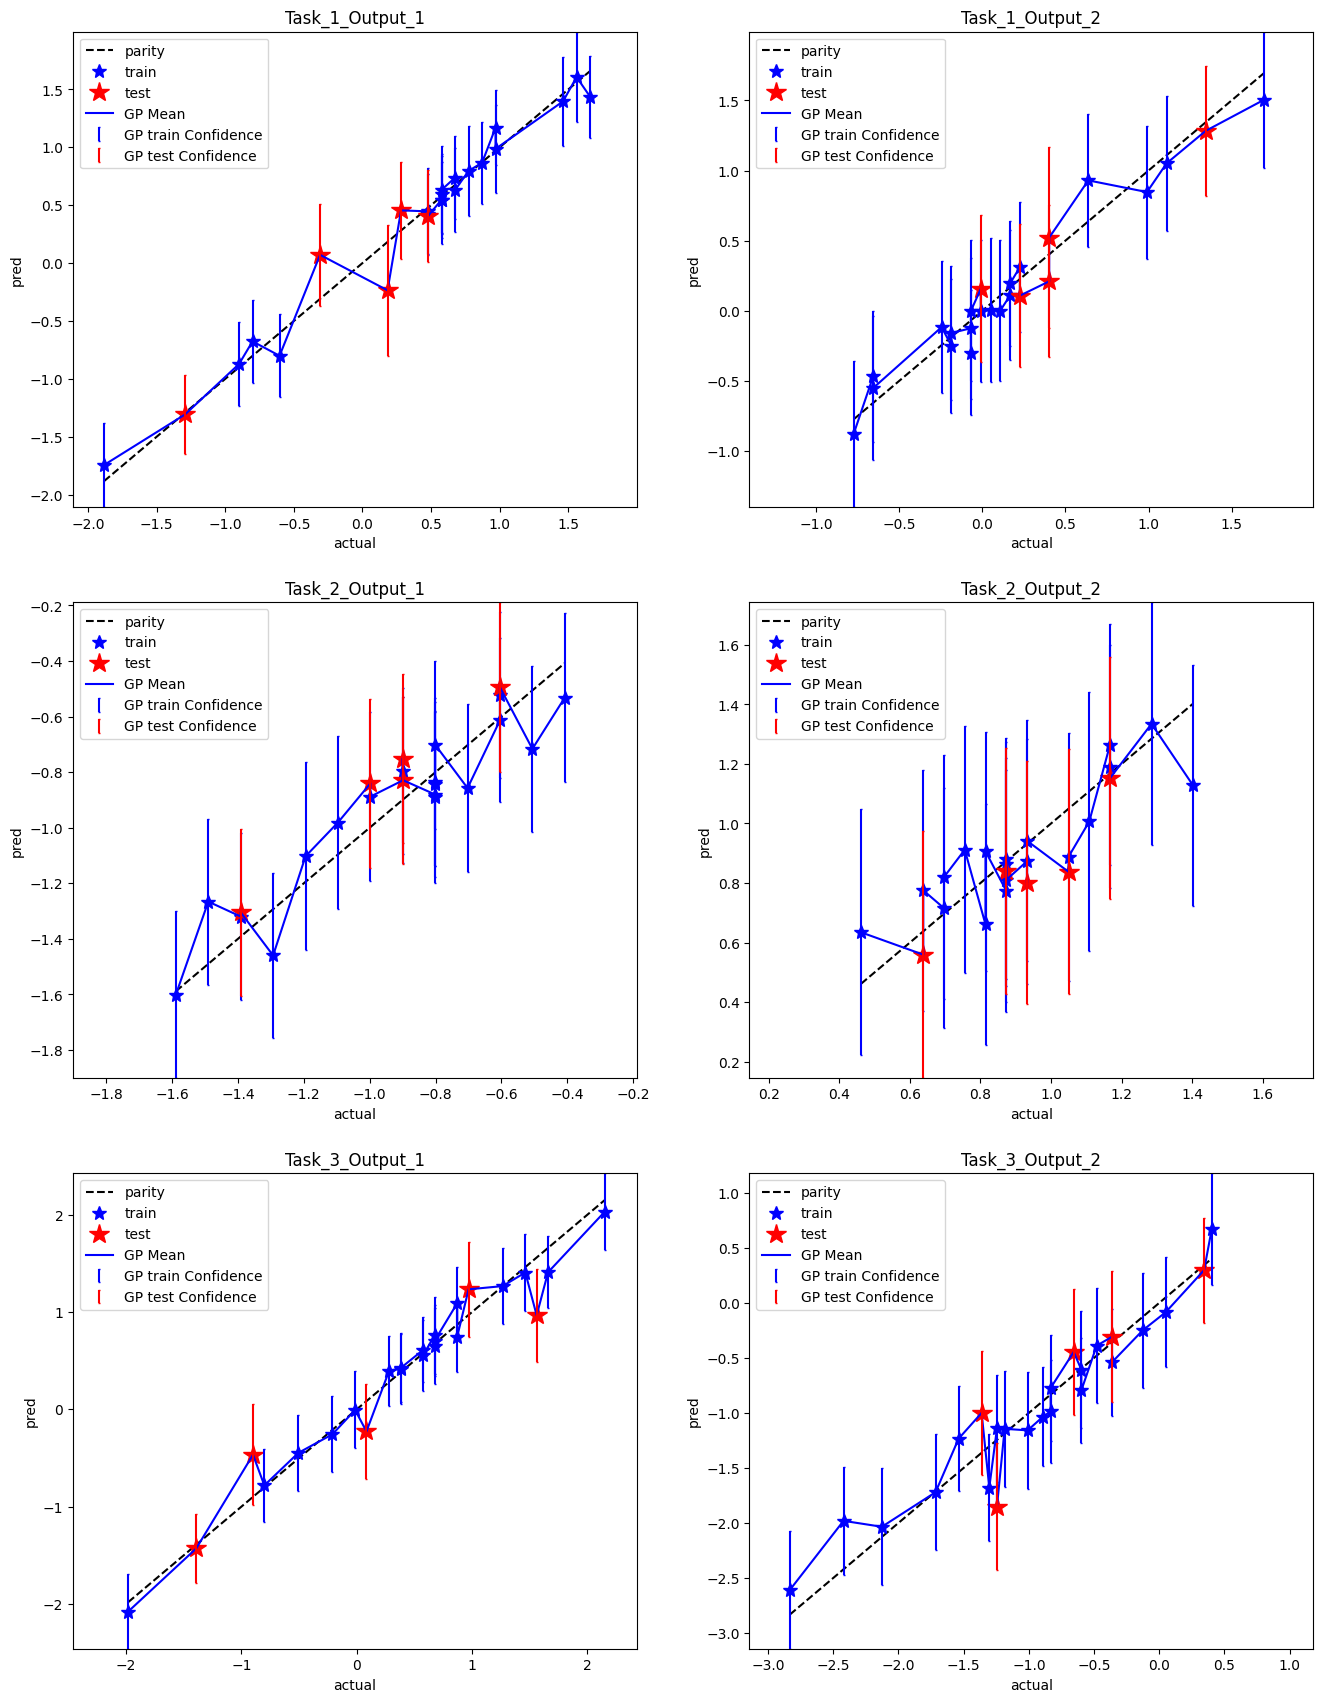

In [448]:
#uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False

# = df_Y[cols_target].min(axis = 0) - 0.4*df_Y[cols_target].std(axis = 0)
#plot_axis_ub = df_Y[cols_target].max(axis = 0) + 0.4* df_Y[cols_target].std(axis = 0)

num_outputs = arr_train_y.shape[-1]
num_tasks = len(np.unique(arr_train_x[..., -1]))

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y
    
    
    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as black stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'b*',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'r*',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      if y_scale_label == 'y-minmax':
        y_axes[a].set_xlim([0,1])
        y_axes[a].set_ylim([0,1])
      elif y_scale_label == 'y-stand':
        y_axes[a].set_xlim([-2.5,2.5])
        y_axes[a].set_ylim([-2.5,2.5])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1))
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std)/np.mean(y_true),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)


if is_set_axis_limit:
  plt.savefig(figPath+'/scaled-true-pred-errorbar.jpg')
else:
  plt.savefig(figPath+'/scaled-true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/scaled_df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/scaled_df_test_metrics.csv')

In [ ]:
#simulate sythetic data
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=t_test_x.shape[1]-1, seed = 10)
sample = sampler.random(n=50)
#sample
syn_task_ind = np.zeros((sample.shape[0]))
for j in range(sample.shape[0]):
    syn_task_ind[j] = np.random.randint(0,3)